In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score


In [19]:
max_accuracy = []
result_acc_ds1, result_acc_ds2 = [], []

Đọc Dataset1

In [20]:
import pickle 

with open('preprocessing/heart/X.pkl', 'rb') as f:
    X = pickle.load(f)
    X = np.array(X)
with open('preprocessing/heart/y.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)


print('So luong du lieu: ', len(X))
print('So luong nhan: ', len(y))

lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)
y = y.reshape(1, -1)[0]
y



So luong du lieu:  1025
So luong nhan:  1025


array([0, 0, 0, ..., 0, 1, 0])

Chia tập train, test Dataset1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=10)



Mô hình SVM tự triển khai

In [22]:
class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=500, degree=2, gamma=1):
    self.kernel = {'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter
  # limit aj
  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
   
    self.X = X.copy()
     # Convert y to {-1, 1}
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2

In [23]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train_test, label, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std
    
def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

def plot_line(title, xlabel, X, Y, f1_Score, classes):
    plt.figure(figsize=(6, 4))
    f1_Score = list(zip(*f1_Score))
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    color = ['g', 'b', 'c', 'm']
    plt.plot(X, Y, linestyle='solid', marker='o', color = 'r', label=classes[0])
    for i in range(len(f1_Score)):
        plt.plot(X, f1_Score[i], linestyle='solid', marker='o', color = color[i], label=classes[i+1])
    plt.legend(loc='best')

Thay đổi kernel giữ nguyên C=1

- Acc = 0.8636363636363636
- Acc = 0.987012987012987


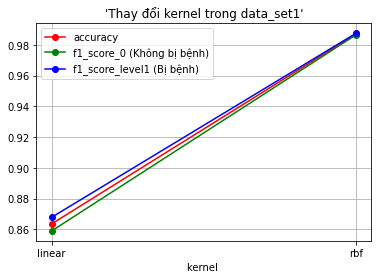

In [24]:
from sklearn.metrics import accuracy_score
title="'Thay đổi kernel trong data_set1'"
xlabel = "kernel "
X = []
Y = []
error = []
f1_Score = []
arr_K=['linear','rbf']
for k_test in arr_K:
  #  print(C_test)
    #model=svm.SVC(C=1.0,kernel=k_test)
    model=SVM(C=1,kernel=k_test,max_iter=300,gamma=0.2)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("- Acc = {}".format(acc))
    X.append(k_test)
    Y.append(acc)
    error.append(0.01)
    f1_Score.append(list(f1_score(y_test, y_pred, average=None)))
# lưu kết quả ra file ảnh
#plot(title, xlabel, X, Y, error)
plot_line(title, xlabel, X, Y, f1_Score, ['accuracy', 'f1_score_0 (Không bị bệnh)', 
'f1_score_level1 (Bị bệnh)'])
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()


Chọn kernel có acc cao hơn là rbf, tiếp tục thay đổi C để đạt kết quả tối ưu

0.0001
- Acc = 0.5194805194805194
0.1
- Acc = 0.922077922077922
1
- Acc = 1.0
5
- Acc = 1.0
10
- Acc = 1.0
15
- Acc = 1.0


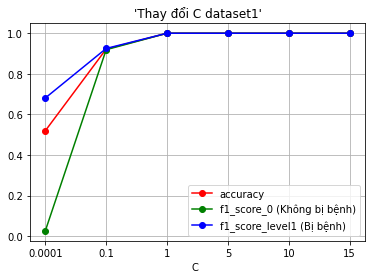

In [25]:
from sklearn.metrics import accuracy_score
title="'Thay đổi C dataset1'"
xlabel = "C "
X = []
Y = []
error = []
f1_Score=[]
arr_c=[0.0001,0.1,1,5,10,15]
for C_test in arr_c:
    print(C_test)
    #model=svm.SVC(C=C_test,kernel='rbf')
    model=SVM(C=C_test,kernel='rbf',max_iter=500,gamma=0.25)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("- Acc = {}".format(acc))
    X.append(str(C_test))
    Y.append(acc)
    error.append(0.01)
    f1_Score.append(list(f1_score(y_test, y_pred, average=None)))
# lưu kết quả ra file ảnh
plot_line(title, xlabel, X, Y, f1_Score, ['accuracy', 'f1_score_0 (Không bị bệnh)','f1_score_level1 (Bị bệnh)'])
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

In [26]:
print("- Training ...")


# X_train.shape
print("- Train size = {}".format(X_train.shape))
model=SVM(max_iter=300,kernel='rbf',C=1,gamma=0.25)
model2=svm.SVC(C=1,kernel='rbf')
print(y_train.dtype)
model.fit(X_train, y_train)
model2.fit(X_train,y_train)
print("- model - train complete")

- Training ...
- Train size = (871, 30)
int32
- model - train complete


In [27]:
from sklearn.metrics import accuracy_score

print("- Testing ...")
y_pred=model.predict(X_test)
y_pred2=model2.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
max_accuracy.append(accuracy_score(y_test, y_pred))
max_accuracy.append(accuracy_score(y_test, y_pred2))
result_acc_ds1.append(accuracy_score(y_test, y_pred))
result_acc_ds1.append(accuracy_score(y_test, y_pred2))

- Testing ...
- Acc = 1.0


In [28]:
from sklearn.metrics import precision_score, recall_score
recall_s = recall_score(y_test, model.predict(X_test), average=None)
print('Tỉ lệ dự đoán đúng người bị bệnh là ', recall_s[1])
print('Tỉ lệ dự đoán đúng người không bị bệnh là', recall_s[0])
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Tỉ lệ dự đoán đúng người bị bệnh là  1.0
Tỉ lệ dự đoán đúng người không bị bệnh là 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        79

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



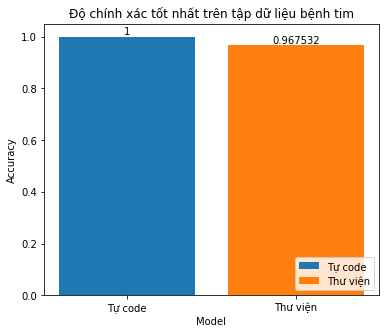

In [29]:
fig = plt.figure(figsize = (6, 5))
labels = ["Tự code", "Thư viện"]
# creating the bar plot
p1 = plt.bar(labels[0], max_accuracy[0])
p2 = plt.bar(labels[1], max_accuracy[1])

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Độ chính xác tốt nhất trên tập dữ liệu bệnh tim")
plt.bar_label(p1)
plt.bar_label(p2)
plt.xticks(np.arange(len(labels)), labels)
plt.legend(labels, loc ="lower right")
plt.show()


Đọc Dataset2


In [30]:
#dataset 2 bệnh xơ gan
with open('preprocessing/cirrhosis/X.pkl', 'br') as f:
    X_train_test = pickle.load(f)
    #X_train_test = np.array(X_train_test)

with open('preprocessing/cirrhosis/y.pkl', 'rb') as f:
    label = pickle.load(f)
    #label=np.array(label)
print('So luong du lieu: ', len(X_train_test))
print('So luong nhan: ', len(label))
# X_train_test[0:5]
# lb = LabelBinarizer()
# lb.fit(label)
# label = lb.transform(y)
# label = label.reshape(1, -1)[0]


So luong du lieu:  412
So luong nhan:  412


<AxesSubplot:ylabel='Stage'>

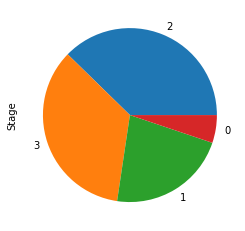

In [31]:
#Dataset 2
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 0)
train_index, test_index = list(cv.split(X_train_test, label))[0]
X_train, X_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index]
y_train, y_test = label.iloc[train_index], label.iloc[test_index]
y_train.value_counts().plot(kind="pie")

100%|██████████| 2/2 [00:00<00:00, 37.84it/s]


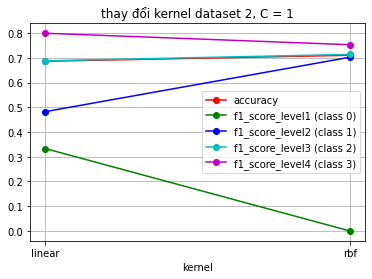

In [32]:
from sklearn.svm import SVC
from tqdm import tqdm
title = "thay đổi kernel dataset 2, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []
f1_Score = []
for kernel in tqdm(['linear','rbf']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    model = SVC(kernel=kernel, C=1)
    model.fit(np.array(X_train),np.array(y_train))
    y_pred = model.predict(np.array(X_test))
    acc = accuracy_score(y_pred, np.array(y_test))
    X.append(kernel)
    Y.append(acc)
    
    f1_Score.append(list(f1_score(y_test, y_pred, average=None)))
# Dataset 2
# Dataset 2
plot_line(title, xlabel, X, Y, f1_Score, ['accuracy', 'f1_score_level1 (class 0)', 
'f1_score_level2 (class 1)', 'f1_score_level3 (class 2)', 'f1_score_level4 (class 3)'])
# lưu kết quả ra file ảnh 
#plot(title, xlabel, X, Y, error)
plt.show()

100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


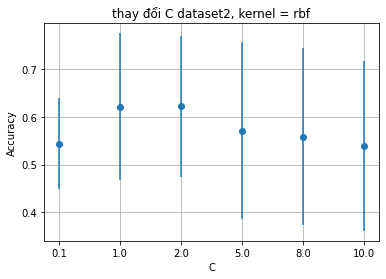

In [33]:
from tqdm import tqdm
title = "thay đổi C dataset2, kernel = rbf"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 8.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel='rbf', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Test với bộ tham số tốt nhất
svm_ = SVC(kernel='rbf', C=2.0)
svm_.fit(X_train, y_train)

print(f'SVM: {accuracy_score(y_test, svm_.predict(X_test))}')
result_acc_ds2.append(0)
result_acc_ds2.append(accuracy_score(y_test, svm_.predict(X_test)))
print(classification_report(y_test, y_pred))

SVM: 0.7349397590361446
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.72      0.68      0.70        19
           2       0.80      0.65      0.71        31
           3       0.65      0.90      0.75        29

    accuracy                           0.71        83
   macro avg       0.54      0.56      0.54        83
weighted avg       0.69      0.71      0.69        83



C:\Users\dovan\anaconda3\envs\course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print([result_acc_ds1, result_acc_ds2])

[[1.0, 0.9675324675324676], [0, 0.7349397590361446]]


In [ ]:
import pickle

with open('result/SVM.pkl', 'wb') as f:
    pickle.dump([result_acc_ds1, result_acc_ds2], f)